v1.2

The objective of this notebook is to: 
- get a baseline from various models
- identify the best performing model(s)
- calculate the **confusion matrix (CM)** per model


# Pre-checks

In [1]:
## Check for Google Drive Connectivity
try:
    from google.colab import drive
    drive.mount('/content/drive')
    google_env = True
except:
    print("Not a Goolge Drive Environment.")
    google_env = False

Not a Goolge Drive Environment.


In [2]:
import time
t_start = time.time()

In [3]:
# Use parameters to enable/disable the fastrun

FASTRUN = False
#FASTRUN = True

# Size of the fastrun dataframe
sample_fraction = 0.01
print("==="*40)
print("Fastrun enabled:", FASTRUN)
if FASTRUN: print("Sample size:",sample_fraction)
print("==="*40)

Fastrun enabled: False


# Setup Environment

## Install Modules

In [4]:
# Required to document module versions
#!pip install catboost
#!pip install xgboost
#!pip install icecream
#!pip install watermark
#!pip install fastparquet

## Import Modules

In [5]:
# Base libraries
import os
from datetime import date

# Scientific libraries
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(15,8)})
sns.set(font_scale=0.8)

# Helper libraries
from watermark import watermark
from icecream import ic
import gc # garbage collection to optimize memory usage: use "gc.collect()"
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

## Global Parameters

In [6]:
seed = 42
cpu_count = os.cpu_count()
cpu_count = cpu_count-2  # to keep machine responsive when fitting the models
notebook_no = "03.02"


## Global Helper Functions

In [7]:
import http.client
import urllib


def send_push(message):
    """Send push notifications to pushover service."""
    try:
        conn = http.client.HTTPSConnection("api.pushover.net:443")
        conn.request("POST", "/1/messages.json",
                     urllib.parse.urlencode({
                         "token": "ahs1q4mwpnxe3645zeaqzas69whq7a",  # ML Notifications Channel
                         "user": "u5vr1qkc9ghudg2ehuug153okeiz1d",
                         "message": message,
                     }), {"Content-type": "application/x-www-form-urlencoded"})

        conn.getresponse()

    except:
        print("There was a communication issue (pushover).")


In [8]:
def fast_run_sampling(df, sample_fraction):
    print("Labels before sampling:\n", df['label'].value_counts())

    # Group by label to ensure to get a balanced sample fraction
    df = df.groupby('label').sample(frac=sample_fraction, random_state=seed)
    print("Labels after sampling:\n", df['label'].value_counts())

    return df


In [9]:
def calculate_duration(t_start, t_end):
    total_runtime = t_end-t_start
    total_runtime_min = round((total_runtime/60), 2)
    print(str(total_runtime_min)+" minutes")

    return total_runtime_min


# 3.0 Load Data

In [10]:
# Load Data
if google_env:
    # Location for "shared with" people
    # create a shortcut of the shared folder in your Google Drive root folder
    ROOT_PATH = "/content/drive/MyDrive/SIADS696/Environment/"
else:
    ROOT_PATH = "../"
    print("Not a Google Drive Environment. Loading local files.")

PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_DATA_MOD = "models/"
PATH_DATA_REP = "reports/"

# Dictionary to store file names and their corresponding dataframes
files = {
    "train_features_clean_stats.parquet.gzip": "df_wiki_train_stats",
    "test_features_clean_stats.parquet.gzip": "df_wiki_test_stats",
    "train_features_rs.parquet.gzip": "df_wiki_train_rs",
    "test_features_rs.parquet.gzip": "df_wiki_test_rs",
    "train_features_nltk.parquet.gzip": "df_wiki_train_nltk",
    "test_features_nltk.parquet.gzip": "df_wiki_test_nltk",
    "train_features_aoa.parquet.gzip": "df_wiki_train_aoa",
    "test_features_aoa.parquet.gzip": "df_wiki_test_aoa",
    "train_features_crb.parquet.gzip": "df_wiki_train_crb",
    "test_features_crb.parquet.gzip": "df_wiki_test_crb",
    "train_features_w2v.parquet.gzip": "df_wiki_train_w2v",
    "test_features_w2v.parquet.gzip": "df_wiki_test_w2v",
   # "train_mNB_predict.parquet.gzip": "df_wiki_train_MNB",  # data leakage risk
   # "test_mNB_predict.parquet.gzip": "df_wiki_test_MNB",    # data leakage risk
}

# Load data into corresponding dataframes
for file, df_name in files.items():
    if df_name not in globals():
        globals()[df_name] = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + file)


Not a Google Drive Environment. Loading local files.


In [11]:
# Combine dataframes into one
df_train = pd.DataFrame()
df_train = pd.concat([df_train, df_wiki_train_stats], axis=1)
df_train = pd.concat([df_train, df_wiki_train_rs], axis=1)
df_train = pd.concat([df_train, df_wiki_train_nltk], axis=1)
df_train = pd.concat([df_train, df_wiki_train_aoa], axis=1)
df_train = pd.concat([df_train, df_wiki_train_crb], axis=1)
df_train = pd.concat([df_train, df_wiki_train_w2v], axis=1)

if FASTRUN:
    df_train = fast_run_sampling(df_train, sample_fraction)


In [12]:
ic(df_train.shape)

ic| df_train.shape: (416768, 155)


(416768, 155)

# 4.0 Base Models

In [13]:
# Model selection
from sklearn.model_selection import StratifiedKFold

# Scaling and pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Linear models
from sklearn.linear_model import LogisticRegression

# Linear/Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier 

# Tree models
from sklearn.tree import DecisionTreeClassifier

# NB models
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Neighbors models
from sklearn.neighbors import KNeighborsClassifier

# Ensemble models
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [14]:
# Classifiers for voting classifier
clf1 = ExtraTreesClassifier()
clf2 = CatBoostClassifier(logging_level='Silent', random_seed=seed)
clf3 = RandomForestClassifier(random_state=seed, n_jobs=cpu_count)
clf4 = XGBClassifier()

eclf1 = VotingClassifier(estimators=[(
    'ExTrees', clf1), ('CatBoost', clf2), ('RF', clf3), ('XGB', clf4)], voting='soft')


In [15]:
model_pipeline = {
    'Random Forest': RandomForestClassifier(random_state=seed, n_jobs=cpu_count),
    #'Extra Trees': ExtraTreesClassifier(),
    #'XGBoost': XGBClassifier(),
    #'CatBoost': CatBoostClassifier(logging_level='Silent', random_seed=seed),
    'Logistic Regression': LogisticRegression(random_state=seed, n_jobs=cpu_count, max_iter=3000),
    'Gaussian NB': GaussianNB(),
    'Multinomial NB': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    #'Voting CLF': eclf1,
    #'MLP Classifier': MLPClassifier(solver='lbfgs', random_state=seed, activation='logistic'),
    #'SGDC': SGDClassifier(),
    #'Dummy': DummyClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    #'Lasso': Lasso(),      # produces nan
    #'Ridge': Ridge(),      # produces nan
    #'ENET': ElasticNet(),  # produces nan
}

#KNC required a lot computational resources because it "memorizes all samples"; 
#could be disabled later; however we need a algo from this model family

In [16]:
X_columns_train = df_train.columns.to_list()
X_columns_train = list(set(X_columns_train) -
                       {"label", "original_text", "cleaned_text", "stats_language_code"})

X = df_train[X_columns_train].copy()
y = df_train["label"]

ic(X.shape);
ic(y.shape);


ic| X.shape: (416768, 151)
ic| y.shape: (416768,)


In [17]:
k=10
skfold = StratifiedKFold(n_splits=k)
rf = RandomForestClassifier(random_state=seed, n_jobs=-1)
scaler = MinMaxScaler((0, 1))


In [18]:
acc_list = []
recall_list = []
precision_list = []
f1_list = []
auc_list = []
cm_list = []

for name, model in model_pipeline.items():
    gc.collect()
    print("")
    print("Fitting:", name)
    
    acc_list_temp = []
    recall_list_temp = []
    precision_list_temp = []
    f1_list_temp = []
    auc_list_temp = []
    cm_list_temp = []
    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_index, test_index in skfold.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Scaling
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        _ = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc_list_temp.append(accuracy_score(y_test, y_pred))
        recall_list_temp.append(recall_score(y_test, y_pred))
        precision_list_temp.append(precision_score(y_test, y_pred))
        f1_list_temp.append(f1_score(y_test, y_pred))
        auc_list_temp.append(roc_auc_score(y_test, y_pred))
        
        # Append targets to calculate confusion matrix later (average values)
        predicted_targets = np.append(predicted_targets, y_pred)
        actual_targets = np.append(actual_targets, y_test)
    
    acc_list.append(np.mean(acc_list_temp))
    recall_list.append(np.mean(recall_list_temp))
    precision_list.append(np.mean(precision_list_temp))
    f1_list.append(np.mean(f1_list_temp))
    auc_list.append(np.mean(auc_list_temp))

    # Calculate confusion matrix with target values from the kfold run
    cm_list.append(confusion_matrix(actual_targets, predicted_targets))

    if not FASTRUN:
        message = (f"KFOLD cross-validation accuracy score base model {name}:", np.mean(acc_list_temp))
        send_push(message)
            
    print("ACC", np.mean(acc_list_temp))


16


Fitting: Random Forest
ACC 0.7486539264550902


48


Fitting: Logistic Regression


/Users/busera/Miniconda/miniconda3/envs/siads696/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/busera/Miniconda/miniconda3/envs/siads696/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

ACC 0.6659988253232807


404


Fitting: Gaussian NB
ACC 0.6199348256420776


0


Fitting: Multinomial NB
ACC 0.6132572455172494


0


Fitting: Decision Tree
ACC 0.6943863266568687


0


Fitting: KNC
ACC 0.6673377009987846


In [19]:
if not FASTRUN:
    send_push("KFOLD Cross-validation base models finished.")

In [20]:
def style_highlight_max(s):
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: darkgreen' if cell else '' for cell in is_max]

In [21]:
result_df = pd.DataFrame({
    'Model': model_pipeline.keys(),
    'Accuracy': acc_list, 
    'Precision': precision_list,
    'Recall': recall_list,
    'F1': f1_list,
    'AUC': auc_list})


# The highlighting does not work for the moment:  .apply(style_highlight_max)\  some numpy array arrow
# It works for the FASTRUN but not for the full run
result_df.style\
    .set_properties(**{'text-align': 'center'})\
    .format(
        {
            'Accuracy': '{:,.3f}',
            'Recall': '{:,.3f}',
            'Precision': '{:,.3f}',
            'F1': '{:,.3f}',
            'AUC': '{:,.3f}',
        })\
    .set_caption(f'<br>Cross-Validation Scores with kFold={k}<br>Fastrun enabled:{FASTRUN}')\
    .set_table_styles([{
        'selector': 'caption',
        'props': 'caption-side: bottom; font-size:0.9em;'}], overwrite=False)\
    .hide_index()


Model,Accuracy,Precision,Recall,F1,AUC
Random Forest,0.749,0.742,0.763,0.752,0.749
Logistic Regression,0.666,0.664,0.674,0.668,0.666
Gaussian NB,0.620,0.596,0.748,0.663,0.620
Multinomial NB,0.613,0.632,0.542,0.583,0.613
Decision Tree,0.694,0.696,0.690,0.693,0.694
KNC,0.667,0.660,0.692,0.675,0.667


In [22]:
today = date.today()

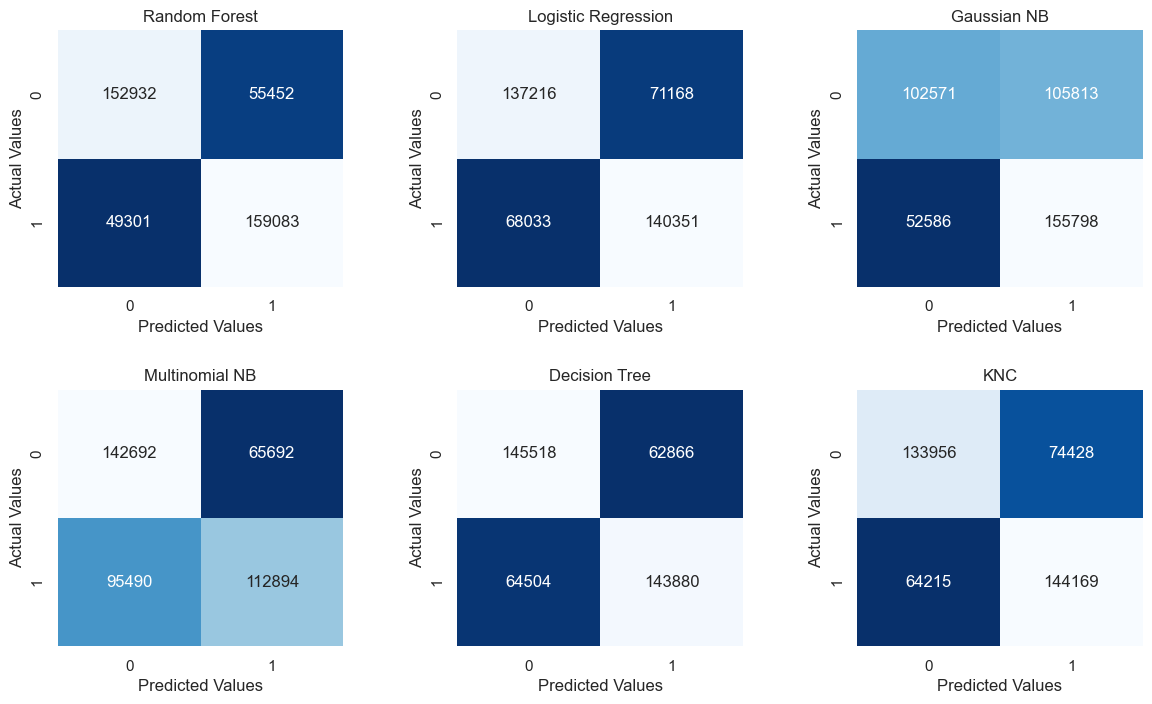

In [23]:
# plot confusion matrix
fig = plt.figure(figsize = (14,8))

# Increase font size
sns.set(font_scale=1)

# Adjust the subplot layout parameters (space between subplots)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

model_list = list(model_pipeline.keys())

for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot (2, 3, i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap = 'Blues_r', fmt='g', cbar=False); 
    _ = cm_plot.set_xlabel('Predicted Values');
    _ = cm_plot.set_ylabel('Actual Values');

# Save the figure
plt.savefig(ROOT_PATH+PATH_DATA_REP+f'figures/{today}_base_models_CV{k}_confusion_matrix_{notebook_no}.png')

In [24]:
t_end = time.time()
calculate_duration(t_start, t_end);


30.24 minutes


# Export

In [25]:
today = date.today()

if not FASTRUN:
    result_df.to_csv(
        ROOT_PATH+PATH_DATA_REP+f"{today}_base_models_KFOLD{k}_scores_table_{notebook_no}.csv", index=False)
   

# Watermark

In [26]:
%watermark

Last updated: 2023-02-27T12:44:35.219241+01:00

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.9.0

Compiler    : Clang 11.0.0 
OS          : Darwin
Release     : 22.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [27]:
%watermark --iversions

matplotlib: 3.6.3
numpy     : 1.23.5
seaborn   : 0.12.2
pandas    : 1.5.3



In [28]:
output_file = f'{ROOT_PATH}{PATH_DATA_REP}/html/{today}_03.02_modeling_base_models_with_CM.html'
!jupyter nbconvert --to html "03.02_modeling_base_models_with_CM.ipynb" --output {output_file}

[NbConvertApp] Converting notebook 03.02_modeling_base_models_with_CM_GC.ipynb to html
[NbConvertApp] Writing 745773 bytes to ../reports/html/2023-02-27_03.02_modeling_base_models_with_CM_GC.html
